# DeepWalk

https://arxiv.org/abs/1403.6652

Paper and algorithm authored by Bryan Perozzi, Rami Al-Rfou, Steven Skiena

Implementation by Rob Forgione

In [ ]:
import numpy as np
from abc import ABC

In [ ]:
import pandas as pd

# Hierarchical Softmax

First, we'll build the components required to use hierarchical softmax. From the paper:

> Computing the partition function (normalization factor) is expensive. If we assign the vertices to the
leaves of a binary tree, the prediction problem turns into
maximizing the probability of a specific path in the tree

Thus, instead of having a classifier that predicts probabilities for each word from our vocabulary (besides the one we're currently iterating on), we can structure the loss function as a binary tree where every internal node contains its own binary classifier. Computing the loss (and gradient) can therefore be done in $O(logv)$ predictions rather than $O(v)$ (as is the case with $v$ labels), where $v$ is the number of vertices in our graph. 

In [ ]:
class Tree(ABC): 
    @staticmethod
    def merge(dims, lr, batch_size, left=None, right=None):
        if left is not None: left.set_left()
        if right is not None: right.set_right()
        return InternalNode(dims, lr, batch_size, left, right)
    
    @staticmethod
    def build_tree(nodes, dims, lr, batch_size):
        if len(nodes) % 2 != 0: nodes.append(None)
        while len(nodes) > 1:
            nodes = [Tree.merge(dims, lr, batch_size, nodes[i], nodes[i+1]) for i in range(0, len(nodes) - 1, 2)]
        return nodes[0]
        
    def set_parent(self, t):
        self.parent = t
        
    def set_left(self): self.is_right = False
        
    def set_right(self): self.is_right = True

In [ ]:
class InternalNode(Tree):
    def __init__(self, dims, lr, batch_size, left=None, right=None, parent=None, is_right=None):
        self.dims = dims
        self.set_left_child(left)
        self.set_right_child(right)
        self.set_parent(parent)
        self.is_right = is_right
        self.params = np.random.uniform(size=self.dims) 
        self.gradients = []
        self.lr = lr
        self.batch_size= batch_size
        
    def set_left_child(self, child: Tree):
        self.left = child
        if self.left is not None:
            self.left.set_parent(self)
            self.left.set_left()
            
    def set_right_child(self, child: Tree):
        self.right = child
        if self.right is not None:
            self.right.set_parent(self)
            self.right.set_right()
            
    def set_parent(self, parent: Tree):
        self.parent = parent    
        
    def predict(self, embedding, right=True):
        d = self.params.dot(embedding) if right else -self.params.dot(embedding)
        return 1/(1+np.exp(-d))
    
    def update_gradients(self, gradient: np.array):
        self.gradients.append(gradient)
        if len(self.gradients) >= self.batch_size:
            avg_gradient = np.stack(self.gradients, axis=0).mean(axis=0)
            self.params = self.params - self.lr * avg_gradient
            self.gradients = []
        
    def __eq__(self, other):
        return (
            self.dims == other.dims and
            self.left == other.left and
            self.right == other.right and
            self.lr == other.lr and
            self.batch_size == other.batch_size
        )

In [ ]:
class Leaf(Tree):
    def __init__(self, vertex, parent: InternalNode = None, is_right = False):
        self.parent = parent
        self.is_right = is_right 
        self.vertex = vertex
        
    def update(self, anchor_vertex):
        node = self
        gradients = []
        total_cost = 0.
        emb_grads = []
        while node.parent is not None:
            is_right = node.is_right
            node = node.parent        
            prob = node.predict(anchor_vertex.embedding, is_right)
            log_prob = np.log(prob)
            total_cost -= log_prob
            u = 1 - prob
            node.update_gradients(u*anchor_vertex.embedding)
            emb_grads.append(u*node.params)
        anchor_vertex.update_embedding(sum(emb_grads))
        return total_cost

In [ ]:
class Vertex(object):
    def __init__(self, dim, lr, batch_size):
        self.dim = dim
        self.embedding = np.random.uniform(size=dim)
        self.lr = lr
        self.gradients = []
        self.batch_size = batch_size
        
    def update_embedding(self, gradient: np.array): 
        self.gradients.append(gradient)
        if len(self.gradients) >= self.batch_size:
            avg_gradient = np.stack(self.gradients, axis=0).mean(axis=0)
            self.embedding = self.embedding - self.lr * avg_gradient
            self.gradients = []

In [ ]:
v = Vertex(8, 1e-1, 1)
v2 = Vertex(8, 1e-1, 1)
leaf = Leaf(v)
leaf2 = Leaf(v2)
i = InternalNode(8, 1e-1, 1, leaf, leaf2)

In [ ]:
before = leaf2.vertex.embedding
before_parent = leaf.parent.params
print(before)

[0.03223765 0.3226532  0.16387155 0.29200162 0.00437034 0.54527208
 0.56576767 0.19339575]


In [ ]:
leaf.update(leaf2.vertex)
after = leaf2.vertex.embedding
after_parent = leaf.parent.params
print(after)

[-0.04365326  0.31753652  0.11360531  0.21441985 -0.00137745  0.49015317
  0.49215809  0.15314094]


Leaves 1 and 2 should share parent `i`. Also, each should have its own vertex (`v` and `v2` respectively).

In [ ]:
assert leaf.vertex == v
assert leaf.vertex != v2
assert leaf2.vertex == v2
assert leaf2.vertex != v
assert leaf.parent == i
assert leaf2.parent == i

As a convenience method, we have `Tree.merge` which should do the same thing as the manual passing to the `InternalNode` constructor above.

In [ ]:
i2 = Tree.merge(8, 1e-1, 1, leaf, leaf2)

In [ ]:
assert i2 == i

We should be able to create an internal node with a single child.

In [ ]:
i3 = InternalNode(8, 0.01, 1, leaf)
assert i3.left == leaf
assert i3.right is None

We should be able to combine two internal nodes under a third internal node.

In [ ]:
two_internal_nodes = Tree.merge(8, 0.01, 1, i, i2)

In [ ]:
assert two_internal_nodes.left == i
assert two_internal_nodes.right == i2
assert i.parent == two_internal_nodes
assert i2.parent == two_internal_nodes

In [ ]:
p = Tree.merge(8, 1e-1, 1, leaf, leaf2)

In [ ]:
leaf.parent == leaf2.parent

True

In [ ]:
leaf.vertex.embedding

array([0.57421171, 0.89109345, 0.49020471, 0.09880393, 0.54335414,
       0.71131765, 0.94493146, 0.95183292])

In [ ]:
before = leaf2.vertex.embedding.copy()
before_parent = leaf.parent.params.copy()
leaf.update(leaf2.vertex)
after = leaf2.vertex.embedding
after_parent = leaf.parent.params
(before, after)

(array([-0.04365326,  0.31753652,  0.11360531,  0.21441985, -0.00137745,
         0.49015317,  0.49215809,  0.15314094]),
 array([-0.08939402,  0.29243513,  0.06930527,  0.17732632, -0.03693688,
         0.45407729,  0.47417043,  0.09828541]))

In [ ]:
(before_parent, after_parent)

(array([0.65550683, 0.38344525, 0.64568738, 0.54893613, 0.51186067,
        0.55343668, 0.29315623, 0.80040314]),
 array([0.65853889, 0.36138982, 0.63779659, 0.53404297, 0.51195635,
        0.51939165, 0.25897194, 0.78976629]))

In [ ]:
assert leaf.parent.predict(leaf2.vertex.embedding, right=False) + leaf.parent.predict(leaf2.vertex.embedding)

In [ ]:
leaf.parent.predict(leaf2.vertex.embedding)

0.6463582234563418

In [ ]:
new_leaf = Leaf(Vertex(8, 0.01, 1))
new_leaf2 = Leaf(Vertex(8, 0.01, 1))
merged = Tree.merge(8, 0.01, 1, new_leaf, new_leaf2)
before1 = new_leaf2.vertex.embedding.copy()
new_leaf.update(new_leaf2.vertex)
after1 = new_leaf2.vertex.embedding
(before1, after1)

(array([0.27455604, 0.34814258, 0.43440521, 0.95940785, 0.85854161,
        0.23150811, 0.52104126, 0.61402351]),
 array([0.26913689, 0.33986203, 0.43305332, 0.95160861, 0.85232982,
        0.23064854, 0.51386623, 0.61193768]))

In [ ]:
before2 = new_leaf.vertex.embedding.copy()
new_leaf2.update(new_leaf.vertex)
after2 = new_leaf.vertex.embedding
(before2, after2)

(array([0.90707282, 0.36027912, 0.54007606, 0.07265559, 0.51549526,
        0.09851681, 0.62584748, 0.843912  ]),
 array([0.9063911 , 0.35923605, 0.53990642, 0.07167278, 0.51471312,
        0.09840862, 0.6249441 , 0.84365028]))

In [ ]:
emb_length = 10
lr = 1e-3
bs = 100
v1 = Vertex(emb_length, lr, bs)
v2 = Vertex(emb_length, lr, bs)
v3 = Vertex(emb_length, lr, bs)
random_walk = [v1, v2, v3]
leaves = list(map(lambda x: Leaf(x), random_walk))
tree = Tree.build_tree(leaves, emb_length, lr, bs)

In [ ]:
leaves

 None]

In [ ]:
tree.__class__

__main__.InternalNode

In [ ]:
v1.embedding.shape, v2.embedding.shape, v3.embedding.shape

((10,), (10,), (10,))

In [ ]:
leaf1, leaf2, leaf3, empty_leaf = leaves

In [ ]:
leaf3.vertex.embedding

array([5.48734770e-01, 9.27553419e-01, 2.86707996e-04, 3.33459859e-01,
       8.22028315e-01, 6.85150861e-01, 7.50806058e-01, 6.89828722e-01,
       8.76249896e-01, 4.51802297e-01])

In [ ]:
leaf1.parent, leaf2.parent, leaf3.parent

(<__main__.InternalNode at 0x127bf2390>,
 <__main__.InternalNode at 0x127bf20f0>)

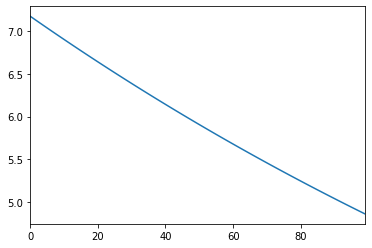

In [ ]:
costs1 = []
costs3 = []
combined_cost = []
for i in range(10000):
    cost1 = leaf1.update(leaf2.vertex)
    cost3 = leaf3.update(leaf2.vertex)
    if i % bs == 0:
        costs1.append(cost1) 
        costs3.append(cost3)
        combined_cost.append(cost1+cost3) 
    
pd.Series(costs1).plot(kind='line')

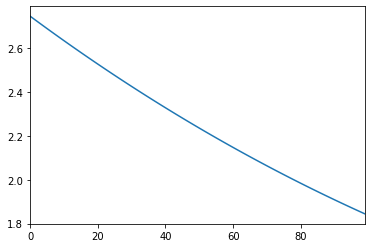

In [ ]:
pd.Series(costs3).plot(kind='line')

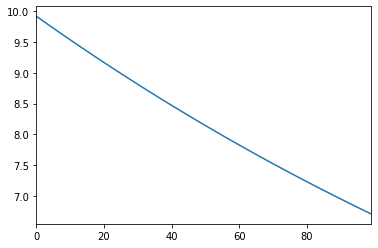

In [ ]:
pd.Series(combined_cost).plot(kind='line')

In [ ]:
emb_length, lr, bs = 10, 1e-4, 100
leaves = [Vertex(emb_length, lr, bs) for i in range(100)]

In [ ]:
leaves = [Leaf(v) for v in leaves]

In [ ]:
tree = Tree.build_tree(leaves, emb_length, lr, bs)

In [ ]:
chosen_leaf = leaves[20]

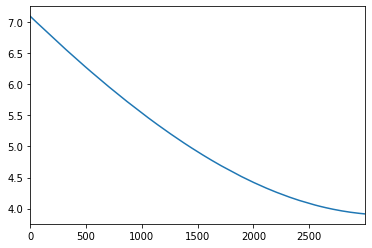

In [ ]:
#slow
costs = []
num_iter = 3000
epoch_costs = [] 
for it in range(num_iter):
    for i in range(100):
        if i == 20:
            continue
        costs.append(leaves[i].update(chosen_leaf.vertex)) 
    epoch_costs.append(np.mean(costs))
    costs = []
s = pd.Series(epoch_costs)
s.plot(kind='line')

This is an interesting result -- it seems a little unusual that we would see training loss going up, but some things to consider:
* In the "real" version, the leaf embeddings are (hopefully) going to have some relationship with the internal node model parameters. In this toy version, we've uniformly initialized all parameters and then trained the model on every single leaf for many iterations. It's basically learning how to optimize random noise.
* We're using plain vanilla batch GD here, with no learning rate annealing (or any of the wide number of GD enhancements that exist). It's very possible that we're getting gradient explosions / divergence towards the end here. 

The goal of hierarchical softmax is to make the scoring function run in $O(logv)$ rather than $O(v)$ by organizing the nodes as a binary tree with a binary classifier at each internal node. At a high level, we follow these steps:
1. We identify a leaf that is contained within the window of our vertex within the current random walk
2. We take that leaf's parent and compute the probability of having followed the correct path (left or right) to the leaf we identified in step 1 by using the model parameters for this internal node combined with the features for the current vertex (which is a row in $\Phi$).
3. We repeat step 2 for all internal nodes until we get to the root
4. The product of all of the internal probabilities gives us the probability of seeing a co-occurrence of the neighbor node given what we know about the node we're exploring
5. $-logPr(u_k|\Phi(v_j))$ is our loss function, where $Pr(u_k|\Phi(v_j))$ is the probability we calculated in step 4
6. We use the loss in step 5 to perform a gradient descent step updating both the parameters of our model and $\Phi(v_j)$:

$$\theta \leftarrow \theta - \alpha_\theta * \frac{\partial J}{\partial \theta}$$
<br>
$$\Phi \leftarrow \Phi - \alpha_\Phi * \frac{\partial J}{\partial \Phi}$$

Where $\theta$ represents all of the parameters of all of the models in the internal nodes of the tree, and $\Phi$ represents the latent representation of the current vertex.

# Alternative Approach (NOTE: this is not in use)

We could have a matrix $W \in \mathbb{R}^{|V| \times d}$ where $d$ is the embedding size and $|V|$ is the number of internal nodes in the tree, where an internal node is defined as one in or before the penultimate layer of the tree. The probability of each node picking its right child is equal to $\sigma(Wl)$ where $\sigma$ is the logistic function and $l$ is the embedding of the listing we're predicting for. We can index into $W$ by taking only the rows that are relevant to the path to the current vertex $v_i$, reducing the dimensionality of $W$ to $\mathbb{R}^{log(|V|)\times d}$. We can produce a vector $z$ with $z_i \in \{0,1\}$ such that $z - \sigma(Wl)$ is the probability of following the path to $v_i$. $z$ is produced by creating an array of length $log(\gamma) - 1$ and setting the even-positions to the value 1. If the tree has $\gamma - |V|$ total vertices, then the last $\gamma - |V|$ elements in the array must therefore be the leaves. 

In [ ]:
# np.array([[1,2,3], [4,5,6], [7,8,9]])[[0,2], :]

In [ ]:
# walk = ["v1", "v2", "v3", "v4"]

In [ ]:
# in this case "i" stands for internal so that it's easy to 
# visually distinguish between internal nodes and leaves.
# tree = ["i1", "i2", "i3", "v1", "v2", "v3", "v4"]

In [ ]:
# init_weights = np.random.normal(size=(len(tree), 10))

In [ ]:
# init.shape

In [ ]:
# for i in range(len(tree)):
#     rows = []
#     idx = len(tree) - 1 - i
#     while idx > 0:
#         idx = (idx - 1)//2
#         rows.append(idx) 
#     rows = np.array(rows)
#     z = (rows % 2 != 0)*1
#     if len(rows) > 0:
#         mat = init[rows, :]
#         print(mat.shape)

In [ ]:
# init[[0,2],:]

# Random Walk

In [ ]:
def random_walk(initial_vertex, walk_length):
    num_steps = 0
    vertex = initial_vertex
    walk = []
    while num_steps < walk_length:
        neighbors = vertex.get_neighbors()
        chosen_neighbor = np.random.choice(neighbors)
        walk.append(chosen_neighbor)
        num_steps += 1
        vertex = chosen_neighbor
    return walk

# Skipgram

In [ ]:
def skipgram(phi, W, window_size):
    for i in range(len(W)):
        v = W[i]
        idx_lower = np.min(i - window_size, 0)
        idx_upper = np.max(i + window_size, len(W))
        neighbors = W[idx_lower:idx_upper]

# DeepWalk

In [ ]:
def deepwalk(g, window_size, embedding_size, walks_per_vertex, walk_length):
    phi = np.random.uniform(0., 1., (g.size, embedding_size))
    for i in range(0, walks_per_vertex): 
        shuffled_nodes = g.shuffle().nodes()
        for v in shuffled_nodes:
            W = random_walk(g, v, walk_length)
            skipgram(phi, W, window_size)